# Logistic Regression

**So far we have seen models for predicting continuous dependent variables from continuous independent variables. What if we have a categorical outcome?**

In this unit we will see our first model for classifying data. We will start with the simplest case, yes/no data. 

At a high level we want to determine whether or now an item that is described with a set of features belongs to a particular class. For example, a customer might choose to buy or not, based on price, or a patient might have an adverse event based on blood glucose levels. We will then examine more advanced models which can classify data that could belong to one of many classes. Finally, we'll take a glimpse at a unifying model which captures all of the classification and regression problems we've done up until now.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from sklearn import linear_model

from sklearn.datasets import make_blobs

## Categorical Data

Previously we've seen models where both independent and dependent variable are numeric values. This is ideal to order to model relations between things like square footage and housing prices.  

Now we are interested in modeling the relation between variables where the dependent variable is categorical. Categorical variables model discrete choices. For example, will a person purchase a home or which country will be the location of Amazon's new office? 

For ease of notation we'll say a data point is made of two components $(x,y)$. The dependent variable $y$ is the class of the datapoint, it must be discrete, it belongs to some predefined set of classes. The independent variable $x$ has $d$ features $x=(x_1,\cdots,x_d)$, each feature could be categorical or numerical.

We'll look at a simple case where the *dependent* variable has only one of two values (for ease, we can refer to them as $0$ and $1$). This is expressed as a binary choice, $y=0$ if a data point does not belong to a specific class and $y=1$ otherwise.

**Note: Logistic regression only gives a binary output (i.e yes/no)**

## Logistic Regression

Logistic Regression is one of the most basic (yet effective) tools we have for classifying categorical data.

With *linear* regression, we modelled data using linear equations of the form: 

$$f(X) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_d x_d$$

This equation outputs numerical predictions from numerical input attributes. Recall that each $\beta_i$ represents how much our model weighs $x_i$ in predicting the output values. 

How can we modify this function to get *categorical* predictions? 

With Logistic Regression, we take advantage of the **sigmoid curve**:
$$ s(X) = \frac{1}{1+e^{-x}} $$

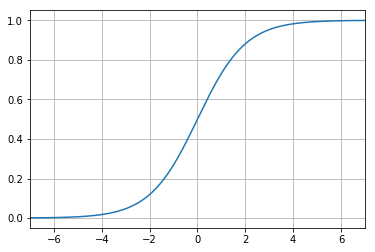

In [2]:
def sigmoid_curve(x):
    return 1 / (1 + np.exp(-x))

x_points = np.arange(-7, 100, 0.01)

plt.figure()
plt.plot(x_points, sigmoid_curve(x_points))
plt.grid()
plt.xlim(-7,7)
plt.show()

We take our familiar linear function...
$$ f(X) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_d x_d $$

... and feed it into the sigmoid curve...
$$ s(X) = \frac{1}{1+e^{-f(X)}} $$

... to create our final predictive model:
$$ s(X) = \frac{1}{1+e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_d x_d)}} $$


Now our model has two nice properties:

    1. It is bounded between 0 and 1 (just like a probability)
    2. It is smooth, it never makes a sharp jump
    
The first property means that we can interpret $s(X)$ as the probability that $X$ belongs to a particular class (say class $1$). By extension, this also gives us the probability that $X$ belongs to the other class, $1-s(X)$. The second property is not as directly useful to us, but it makes it easy for Python to solve several underlying equations when fitting the model, (e.g. the gradient of the function).

Once we have our model's estimate we can make a decision on which class it belongs to. Since $X$ must belong to one of the two classes, we assign it to the class our model believes is more likely. This is to say that we assign it to class $1$ if $s(X) \geq 1-s(X)$, otherwise we assign it to class $0$. 

#### Optimizing the Function (Bonus Material)

To actually fit the model to data $((x^1,y^1),\cdots,(x^n,y^n))$ we aim to maximize the likelihood of model:

$$\Pi_{i=1}^n s (x^i)^{y^i} \cdot (1-s (x^i))^{(1-y^i)}$$

Recall, $s(x^i)$ represents the probability our model assigns to $y^i=1$. This is its belief that $y_i$ is actually $1$. If $y^i$ is actually $1$ then only $s(x^i)^{y^i}$ will contribute to the likelihood of our model. In this case the higher $s(x^i)$ is, the larger this function becomes. Conversly, if $y^i$ is $0$ only $1-s(x^i)$ contributes, and the lower $s(x^i)$ is better.

It isn't obvious how we actually maximize this. Unlike linear regression, there is no way to find an optimal solution. Instead we have several heuristic solvers which do pretty well in practice. Each solver has its advantages and disadvantages. Keep in mind that they end up finding different solutions.

#### A First Example

Let's look at an example.  Suppose 25 candidates with similar work experience interview for similar jobs at the same large company, in different offices, and spent between 0 and 3 hours researching the company before the interview.  A question we may ask is "how is the probability that the candidate will be hired affected by how long they spent researching the company"?

In the language of our model each candidate is a data point (i.e row), the hours they spend researching is the only feature of the independent variable, while the hiring decision is the dependent variable. Hiring in this case is a categorical outcome - either you are hired or not.

Equation: 
$$ f(X) = \beta_0 + \beta_1 x $$ , where x is the number of hours researched

In [3]:
cr = pd.DataFrame({'Hours Researched':[0, 0, 0.5, 0.75, 1.0, 1.0, 1.25, 1.25, 1.5, 1.5, 1.75, 1.75, 
                                       1.9, 2.0, 2.0, 2.0, 2.0, 2.25, 2.25, 2.25, 2.5, 2.5, 2.75, 3.0, 3.0],
                   'Hired':[0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1]})

cr.head(10)

,Hours Researched,Hired
0,0.00,0
1,0.00,0
2,0.50,0
3,0.75,0
4,1.00,0
5,1.00,0
6,1.25,1
7,1.25,0
8,1.50,0
9,1.50,0


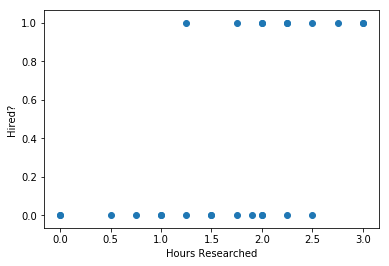

In [4]:
plt.figure()
plt.scatter(cr['Hours Researched'], cr['Hired'])
plt.xlabel('Hours Researched')
plt.ylabel('Hired?')
plt.show()

#### Fitting a Model with Scikit-Learn

We can use scikit-learn's `linear_model.LogisticRegression()` to create a logistic regression model for our data. 

We set a variable name, like `my_model`, to an instance of the logistic regression, and then call `my_model.fit(x,y)` for our data.


Since the model can be used to fit independent variables with multiple features we must pass in each data point as an array (even though each array only contains one element in our particular example). If we tried to just pass in the raw data (not in an array) as`cr['Hours Researched']` we would get an error. Instead we need to reshape the data in the following way:

In [5]:
cr['Hours Researched'].values.reshape(-1,1) #note: this converts it from an array (25,) to (25,1) array. We tell it to .reshape(#rows, #columns)
#we use -1 as #rows to say use all rows

#cr['Hours Researched'].values.shape
#cr['Hours Researched'].values.reshape(-1,1).shape

array([[0.  ],
       [0.  ],
       [0.5 ],
       [0.75],
       [1.  ],
       [1.  ],
       [1.25],
       [1.25],
       [1.5 ],
       [1.5 ],
       [1.75],
       [1.75],
       [1.9 ],
       [2.  ],
       [2.  ],
       [2.  ],
       [2.  ],
       [2.25],
       [2.25],
       [2.25],
       [2.5 ],
       [2.5 ],
       [2.75],
       [3.  ],
       [3.  ]])

We call our model instance `my_logreg`, and fit our data to it:

In [6]:
# Define our X and our y
X = cr['Hours Researched'].values.reshape(-1,1)
y = cr['Hired'].values

# Create an instance of our model and fit the model
my_logreg = linear_model.LogisticRegression().fit(X,y)

# Fit the model to data - this also works as it its inplace
#my_logreg.fit(X,y)


C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Since our independent variable only has one feature (the number of hours studied) there are only fit two $\beta_i$ values. The coefficient for the number of hours studied ($\beta_1$) and the bias term ($\beta_0$). We can get these from the `LogisticRegression` object with:

In [7]:
hours_researched_slope = my_logreg.coef_[0][0]
my_logreg.coef_[0][0]

0.6904344919154154

In [8]:
hours_researched_intercept = my_logreg.intercept_[0]
my_logreg.intercept_[0]

-1.3777281152462846

These are the two values Python learned, which means that they best explain the data we fed the model. Now we can plot the logistic function with our parameters:
$$ s(X) = P(y|X) = \frac{1}{1+e^{-(0.690x - 1.378)}}$$

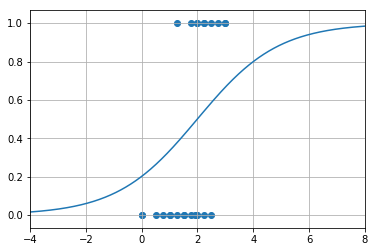

In [9]:
a = my_logreg.coef_[0][0]
b = my_logreg.intercept_[0]

plt.figure()
plt.plot(x_points, sigmoid_curve(a * x_points + b))
plt.scatter(cr['Hours Researched'], cr['Hired'])
plt.grid()
plt.xlim(-4,8)
plt.show()

With a visual inspection of the model we see the lowest probability that it ever assigns is around $5\%$. This means that it never entirely rules out the chance that someone will be hired, after $6$ hours it is almost at $100\%$. This illustrates two important points about the model:

    1. It is never 100% confident that someone will be hired or not, it always has a slight buffer built in
    2. It is making assmptions about data beyond the range of its inputs, the largest value it saw was 3
    
Note that the plot includes negative values for x. This is not meaningful to interpet, but it gives a better feel for how the model fits.

With our trained model we can make predictions about data points we've never seen before:

In [10]:
# Generating new data to test out on our model
hours_studied = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

ph = pd.DataFrame({'Hours Researched': hours_studied,
                   'Prob. of Hiring': [sigmoid_curve(a*x + b) for x in hours_studied]})
ph

,Hours Researched,Prob. of Hiring
0,0.0,0.201374
1,0.5,0.262598
2,1.0,0.334635
3,1.5,0.415305
4,2.0,0.500785
5,2.5,0.586219
6,3.0,0.666762
7,3.5,0.738617
8,4.0,0.799634
9,4.5,0.849314


Scikit-learn also has a in-built `.predict()` function for our regression model which will output either `0` (does not belong to class) or `1` (belongs to class) for a given argument. We can use this with our trained model to see if various values for hours studied is sufficient to be hired.

In [11]:
hours_studied = np.array(hours_studied).reshape(-1,1)

predictions = my_logreg.predict(hours_studied)
#predictions
for i in range(len(hours_studied)) :
    if predictions[i] == 1 :
        print("Model predicts:", hours_studied[i][0], "hours is sufficient.")
    else :
        print("Model predicts:", hours_studied[i][0], "hours is insufficient.")

Model predicts: 0.0 hours is insufficient.
Model predicts: 0.5 hours is insufficient.
Model predicts: 1.0 hours is insufficient.
Model predicts: 1.5 hours is insufficient.
Model predicts: 2.0 hours is sufficient.
Model predicts: 2.5 hours is sufficient.
Model predicts: 3.0 hours is sufficient.
Model predicts: 3.5 hours is sufficient.
Model predicts: 4.0 hours is sufficient.
Model predicts: 4.5 hours is sufficient.


Here, the model predicts that researching anything under 2 hours is insufficient. The cutoff point is actually where $s(x)$ becomes larger than $0.5$ (this is the point where $s(x) \geq 1 - s(x)$). To find this value we can work backwards from the definition of $s(x)$ getting a value of right around $2.0$ hours (how we found this is unimportant). This shows us our model is imperfect, let's look at the original hired data: 

In [12]:
cr.loc[[6,10,20],:]

,Hours Researched,Hired
6,1.25,1
10,1.75,1
20,2.50,0


Our model would mispredict all of these examples. This would happen despite the fact we trained the model on all of these points! This isn't just a short coming of logistic regression, it is a shortcoming of *all* linear models. They are named Linear Models because they find linear seperators, while these tend to be fast and easy to train they aren't the most powerful models. Note that from a statistical method, we would expect a certain amount of error. We can never 100% predict every outcome! When our data only has one dimension (such as our example with hours studied) a linear seperator just learns to classify all points to the left of some point as class $0$ and all points to the right as class $1$.

Later in the course we will see more advanced models which can learn non-linear seperators, although for this particular example (and most one-dimensional data) a linear separator is probably the smartest choice.

Once we have any model, we need to evaluate how good it is. When fitting a model to non-categorical dependent variables we saw the $R^2$ error was a reasonable metric. But now we have a direct classification goal.

While we can calculate the likelihood of a set of data $X=(x_1,\cdots,x_m)$ given the model $P(X | model)$ it is often easier, and more intuitive, to work directly with the classification accuracy. The classification accuracy of a model on $X$ is defined as the fraction of points in $X$ which the model correctly labels. 

For our hiring example the classification accuracy can be found using the `score()` method. 

In [13]:
#Recall X is the independent variable and Y is the dependent variable
#logreg has already been fitted to X and Y
print("The classification accuracy is:", my_logreg.score(X, y)* 100 , "%")

The classification accuracy is: 76.0 %


Another approach, used in machine learning, is to divide the data into training and validation sets. The model is fit to the training data, while the validation data is used to evaluate the fit quality. The classification accuracy is taken over each set individually. This is a technique to combat overfitting, the validation data measures how the model would perform on future prediction tasks (representing previously unseen data).

We will discuss this in more detail in a future lecture.

### Exercise:

1. Using `sklearn` fit the following data with a logistic regression model. 
2. Get the coeficients and and plot the function, when is the decision made? At what value do we change our decision?
3. What kind of classification accuracy do we achieve on this data?
4. What if we change the decision boundary. Say we wanted to classify as $1$ if the model set the probability to $80\%$. How would you do this (note you can't use the `score` method anymore). What happens if we set the boundary to $20\%$? 

In [14]:
exerciseData = pd.DataFrame({'independent':range(100),
                   'dependent':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,\
                            1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,\
                            0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,\
                            1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

In [15]:
#1
#see shape of dependent and reshape if needed 
X = exerciseData['independent'].values.reshape(-1,1)
y = exerciseData['dependent'].values

log_model = linear_model.LogisticRegression().fit(X,y)

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


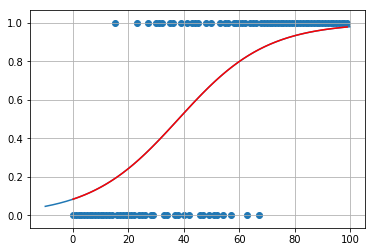

In [16]:
beta_1 = log_model.coef_[0][0]
#log_model.coef_[0][0]
beta_0 = log_model.intercept_[0]

x_points = np.arange(-10,100,0.1)

plt.figure()
plt.scatter(exerciseData['independent'], exerciseData['dependent'])
plt.plot(x_points, sigmoid_curve(beta_0 + beta_1*x_points))
plt.plot(exerciseData['independent'].values, sigmoid_curve(beta_0 + beta_1*exerciseData['independent'].values),color='red')
#plt.plot(X, sigmoid_curve(ind_slope * X + dep_int)
plt.grid()
#plt.xlim(-4,8)
plt.show()

In [17]:
#The threshold is 0.5, what is the x-value at this point?
threshold = -beta_0/beta_1
print(threshold)

38.082268887198175


In [18]:
print(log_model.score(X,y))

0.81


In [19]:
#4 - what if we want decision threshold to be 0.8 instead of 0.5 for predicting class I membership?

for data_point in X:
    data_point = np.array(data_point).reshape(-1,1)
    prob_prediction = log_model.predict_proba(data_point)
    
    if prob_prediction[0][1] >= 0.8:
        print(f'Our model predicts {data_point[0][0]} to be in Class 1')
    else:
        print(f'Nope {data_point[0][0]} does NOT work')
    #print(prob_prediction)



Nope 0 does NOT work
Nope 1 does NOT work
Nope 2 does NOT work
Nope 3 does NOT work
Nope 4 does NOT work
Nope 5 does NOT work
Nope 6 does NOT work
Nope 7 does NOT work
Nope 8 does NOT work
Nope 9 does NOT work
Nope 10 does NOT work
Nope 11 does NOT work
Nope 12 does NOT work
Nope 13 does NOT work
Nope 14 does NOT work
Nope 15 does NOT work
Nope 16 does NOT work
Nope 17 does NOT work
Nope 18 does NOT work
Nope 19 does NOT work
Nope 20 does NOT work
Nope 21 does NOT work
Nope 22 does NOT work
Nope 23 does NOT work
Nope 24 does NOT work
Nope 25 does NOT work
Nope 26 does NOT work
Nope 27 does NOT work
Nope 28 does NOT work
Nope 29 does NOT work
Nope 30 does NOT work
Nope 31 does NOT work
Nope 32 does NOT work
Nope 33 does NOT work
Nope 34 does NOT work
Nope 35 does NOT work
Nope 36 does NOT work
Nope 37 does NOT work
Nope 38 does NOT work
Nope 39 does NOT work
Nope 40 does NOT work
Nope 41 does NOT work
Nope 42 does NOT work
Nope 43 does NOT work
Nope 44 does NOT work
Nope 45 does NOT wor

### Logistic Regression with Multiple Features

The example we saw only had a single feature (hours spent studying). Logistic regression can be extended to multi-dimensional features in much the same way that linear regression can. The key is in the special function $f(x)$, we use it to transform any $d$-dimensional point $x=(x_1,\cdots, x_d)$ into a single number. As we mentioned before this is a special type of function called a linear function, it has the following form:

$$f(X) = \beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2 + \cdots + \beta_d \cdot x_d$$

Which we use inside $s(X)$:

$$ s(X) = \frac{1}{1+ e^{-f(x)}} $$

In our previous example we only had to find $\beta_0$ (the bias term) and $\beta_1$ (the coeficificient for the one feature of the independent variable). Now let's look at a [dataset for loan applications](https://drive.google.com/file/d/1B8of0WSx7vkW66PlC0g0DcJXZjI2Fkgi/view?usp=sharing) with multiple independent variable features:

In [20]:
loans = pd.read_csv('data/loans.csv', index_col=0)
loans.head(10)

,Credit Score,Loan Request Amount,Approval
0,548,56,0
1,625,168,0
2,899,237,1
3,608,84,0
4,783,34,1
5,735,213,0
6,472,213,0
7,661,150,0
8,645,46,1
9,821,247,1


This data contains loan applications for different customers. It contains their credit score (ranging from 300 to 900, with a higher number being better), the loan request amount in \$100s, and the approval being 0 if the loan was denied and 1 if it was approved. 

In the language of regression, the dependent variable is the outcome of the appllication, while the independent variable has two features (credit score and request amount).

Before diving into the data we can look at the correlation between each of the variables:

In [21]:
loans.corr()
#if we have features that correlate with each other, then its a very big chance we will overfit.

,Credit Score,Loan Request Amount,Approval
Credit Score,1.000000,-0.013193,0.796041
Loan Request Amount,-0.013193,1.000000,-0.084494
Approval,0.796041,-0.084494,1.000000


So there is definitely a strong linear relation between score and loan approval, but not nearly as strong a relation between loan amount and approval.  While we will continue with the exercise for illustrative purposes, these are things to keep in mind when selecting our model (the model validation tools we will be learning next unit will also help).  

One thing to note, though, is that there is *not* a strong linear relation between the *independent* variable features.  This is a good sign, because high multicollinearity between features can lead to an increase in standard errors of the model.  In other words, if the features have high multicollinearity, it becomes difficult to ascertain the true impact of each of the features.

We feed the data to the `linear_model.LogisticRegression()` the same as above, but now our `X` consists of multiple columns.

In [22]:
# Define our X and y
X = loans[['Credit Score','Loan Request Amount']]
Y = loans['Approval']

# Instantiate our model
lgrg = linear_model.LogisticRegression()

# Fit our model on the data
lgrg.fit(X,Y)

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

When we look at the coefficient, we would expect two values:

In [23]:
loans_credit_score_coeff = lgrg.coef_[0][0] #beta_1
loans_credit_score_coeff

0.005692841903636719

In [24]:
loans_request_amount_coeff = lgrg.coef_[0][1] #beta_2
loans_request_amount_coeff

-0.009848459410054668

In [25]:
lgrg.coef_

array([[ 0.00569284, -0.00984846]])

And getting the bias term:

In [26]:
loans_intercept = lgrg.intercept_[0] #beta_0
loans_intercept

-2.677789020882764

These are the values of $\beta_1$, $\beta_2$ and $\beta_0$. At a glance these values seem reasonable. The coefficient associated with credit score $\beta_1$ is positive, this means that as an applicants score increases, our model believes it is more likely that their application will be approved. On the other hand $\beta_2$, the coefficient associated with request amount, is negative. This means our model assigns a lower probability of approval as the request amount increases.

As with the one-dimensional model we can visualize this model. However, it will now have three dimensions, one for each feature of the independent variables and one for the probability of the dependent variable.

We can plot this function using the 3D tools from the visualization unit:

In [27]:
import mpl_toolkits.mplot3d as m3d
from scipy import special

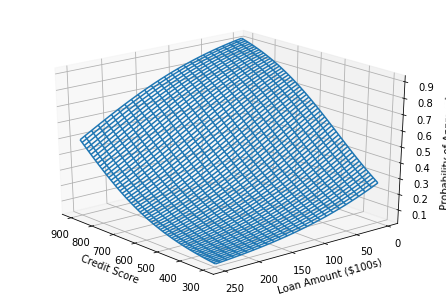

In [28]:
b1 = loans_credit_score_coeff
b2 = loans_request_amount_coeff
b0 = loans_intercept

cr = np.arange(300,900,1)
am = np.arange(2,250,1)
xx, yy = np.meshgrid(cr, am)
Z = special.expit(xx*b1+yy*b2+b0)
fig3d = m3d.Axes3D(plt.figure())
fig3d.plot_wireframe(xx, yy, Z, rstride=10, cstride=10);
fig3d.set_xlabel('Credit Score')
fig3d.set_ylabel('Loan Amount ($100s)')
fig3d.set_zlabel('Probability of Approval')
fig3d.view_init(25, 140)
plt.show();

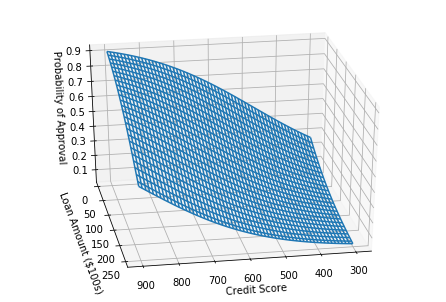

In [29]:
fig3d = m3d.Axes3D(plt.figure())
fig3d.plot_wireframe(xx, yy, Z, rstride=10, cstride=10);
fig3d.set_xlabel('Credit Score')
fig3d.set_ylabel('Loan Amount ($100s)')
fig3d.set_zlabel('Probability of Approval')
fig3d.view_init(30, 80)
plt.show();

With a visual inspection we see this is also a smooth object always bounded between 1 and 0. This means we can interpret any pair of independent variable features as a probability, and as before we can have the model make predictions at these points.

In [30]:
data = [[i, j] for i in [600,700,800] for j in [50,100,150,200,250]]
#data

predictionData = np.array( data )
prediction = lgrg.predict(predictionData)

for i in range(len(data)) :
    if prediction[i] == 1 :
        print("Model Predicts:", "Credit Score of", data[i][0] , "and a loan request of", data[i][1], "will be approved.")
    else :
        print("Model Predicts:", "Credit Score of", data[i][0] , "and a loan request of", data[i][1], "will NOT be approved.")


Model Predicts: Credit Score of 600 and a loan request of 50 will be approved.
Model Predicts: Credit Score of 600 and a loan request of 100 will NOT be approved.
Model Predicts: Credit Score of 600 and a loan request of 150 will NOT be approved.
Model Predicts: Credit Score of 600 and a loan request of 200 will NOT be approved.
Model Predicts: Credit Score of 600 and a loan request of 250 will NOT be approved.
Model Predicts: Credit Score of 700 and a loan request of 50 will be approved.
Model Predicts: Credit Score of 700 and a loan request of 100 will be approved.
Model Predicts: Credit Score of 700 and a loan request of 150 will NOT be approved.
Model Predicts: Credit Score of 700 and a loan request of 200 will NOT be approved.
Model Predicts: Credit Score of 700 and a loan request of 250 will NOT be approved.
Model Predicts: Credit Score of 800 and a loan request of 50 will be approved.
Model Predicts: Credit Score of 800 and a loan request of 100 will be approved.
Model Predicts:

As previously seen we can evaluate the classification accuracy of the model

In [31]:
print("The classification accuracy is:", lgrg.score(X,Y)* 100 , "%")

The classification accuracy is: 88.0 %


### Exercises:

1. Since our independent variable has two features we can fit a *logistic regression* model to each individually. For each feature, fit a model.
2. Plot and compare the two models, what differences do you notice? How would you explain the differences? Try using the correlation matrix to help explain.
3. What classification accuracy do each of your individual models get? How does this compare to the model with two features? Do the underlying features provide any useful information by themselves, did they do better than just guessing? 

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


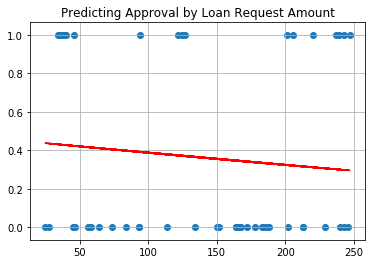

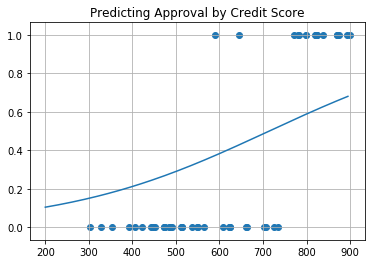

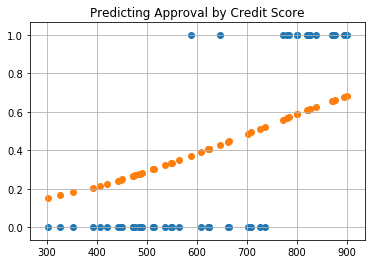

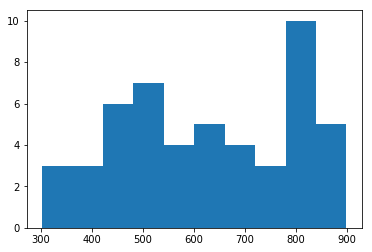

In [46]:
#1
#loans.info()
y= loans['Approval'].values
x_amount = loans['Loan Request Amount'].values.reshape(-1,1)
x_credit = loans['Credit Score'].values.reshape(-1,1)

loan_model = linear_model.LogisticRegression().fit(x_amount,y)
credit_model = linear_model.LogisticRegression().fit(x_credit,y)

loan_coeff = loan_model.coef_[0][0]
credit_coeff = credit_model.coef_[0][0]

loan_int = loan_model.intercept_[0]
credit_int = credit_model.intercept_[0]

plt.figure()
plt.scatter(loans['Loan Request Amount'], loans['Approval'])
#plt.plot(x_points, sigmoid_curve(loan_coeff*x_points + loan_int))
plt.plot(loans['Loan Request Amount'].values, sigmoid_curve(loan_int + loan_coeff*loans['Loan Request Amount'].values),color='red')
#plt.plot(X, sigmoid_curve(ind_slope * X + dep_int)
plt.title('Predicting Approval by Loan Request Amount')
plt.grid()
#plt.xlim(-4,8)
plt.show()


x_cred_points = np.arange(200,900,5)
plt.figure()
plt.scatter(loans['Credit Score'], loans['Approval'])
plt.plot(x_cred_points, sigmoid_curve(credit_coeff*x_cred_points + credit_int))
#plt.plot(loans['Credit Score'].values, sigmoid_curve(credit_int + credi_coeff*loans['Credit Score'].values), color='red')
plt.title('Predicting Approval by Credit Score')
plt.grid()
plt.show()


plt.figure()
plt.scatter(loans['Credit Score'], loans['Approval'])
#plt.plot(x_points, sigmoid_curve(credit_coeff*x_points + credit_int))
plt.scatter(loans['Credit Score'].values, sigmoid_curve(credit_int + credit_coeff*loans['Credit Score'].values))
plt.title('Predicting Approval by Credit Score')
plt.grid()
plt.show()

plt.figure()
plt.hist(loans['Credit Score'].values)
plt.show()

The Loans model is not particualrly useful since the probablities are all below 50% - 
which is like saying the bank will likely not approve you if you ask for money.

So by individual logistic model, credit score may be useful, but does not give the whole picture.

In [33]:
#3 Accuracy
print("The classification accuracy of the Loan Amount model is:", loan_model.score(x_amount,y)* 100 , "%")
print("The classification accuracy of the Credit Score model is:", credit_model.score(x_credit,y)* 100 , "%")
print("The classification accuracy of the multivariate Logistic model is:", lgrg.score(X,Y)* 100 , "%")

The classification accuracy of the Loan Amount model is: 64.0 %
The classification accuracy of the Credit Score model is: 92.0 %
The classification accuracy of the multivariate Logistic model is: 88.0 %


Despite the multivariate model accounting for more variables, but having more variables doesnt mean the prediction will be better

### Statsmodels

We've been using the `sklearn` (a machine learning package) implementation of linear regression up until now. It is also implemented in `statsmodels` (a statistician package). While both models are similar, there are some differences we should go over.

As in the `sklearn` implementation we build a model using the dependent variable ($Y$) and the independent variable ($X$). We then use the `fit()` method to fit the model to the underlying data. The syntax is a bit different than what we've seen, but we'll work through an example here.

In [ ]:
cr = pd.DataFrame({'Hours Researched':[0, 0, 0.5, 0.75, 1.0, 1.0, 1.25, 1.25, 1.5, 1.5, 1.75, 1.75, 
                                       1.9, 2.0, 2.0, 2.0, 2.0, 2.25, 2.25, 2.25, 2.5, 2.5, 2.75, 3.0, 3.0],
                   'Hired':[0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1]})

#The independent variable
X = cr['Hours Researched'].values.reshape(-1,1)
#The dependent variable
Y = cr['Hired']

#Statsmodel DOES NOT include the bias term, we must add a column of ones on to the data to simulate it.
X = np.hstack([np.ones([X.shape[0],1]), X])

#Create an logistic regression instance with our data.
logit = sm.Logit(Y, X)

#Fit the model to the data (this returns a seperate object with the parameters)
fitted_model = logit.fit()

#Statsmodel only returns the probability estimate, we need the manully set the threhold.
prediction = np.where(fitted_model.predict(X) >= 0.5, 1,0)

#The total number the model correctly predicted:
total_correct = np.where(prediction == Y, 1,0).sum()


print ("We got:", total_correct, "out of:", len(Y), "correct.")

### Regularization of Logistic Regression

In a previous lecture we discussed how regularization can be used to combat overfitting, producing models which we are better able to generalize. Most regularization methods work by penalizing the weight coeficients of the model. Here are two of the most common penalization methods. The first is with the $L2$ error:

$$P(\beta) = W\sum_i \beta_i^2$$

We've previously seen this as Ridge Regression. We can also use the $L1$ error:

$$P(\beta) = W\sum_i |\beta_i|$$

And we've seen this as Lasso Regression.

The $W$ term is the weight of the regularization, the higher it is the more it affects the model. Whatever regression we pick the model is now biased to select smaller $\beta$ terms. Since the underlying model goal has been changed, the actual model will likely be different, possibly returning a different solution.

#### Implementing Regularization

Both the `sklearn` and `statsmodel` implementation of logistic regression include regularization options.

In `sklearn` it's actually impossible to turn regularization off. By default they use $L2$ regularization with a weight ($W$) of $1$. We can set the regularization type with the `penalty` parameter and the inverse of the weight with the `C` parameter (in our above equation $W = 1/C$). 

The function has many parameters (for a full list of parameters see http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), but some of the most important ones are:

    1. penalty: The type of regularization method used (defaults to L2)
    2. C: The inverse of the regularization strength (lower values mean a stronger regularization term)
    3. solver: The method used to fit the model (see the documentation for which is appropriate and when)

In order to facilitate visualization let's use the one-dimensional hiring data again:

In [35]:
cr = pd.DataFrame({'Hours Researched':[0, 0, 0.5, 0.75, 1.0, 1.0, 1.25, 1.25, 1.5, 1.5, 1.75, 1.75, 
                                       1.9, 2.0, 2.0, 2.0, 2.0, 2.25, 2.25, 2.25, 2.5, 2.5, 2.75, 3.0, 3.0],
                   'Hired':[0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1]})

X = cr['Hours Researched'].values.reshape(-1,1)
Y = cr['Hired']

We can build two models, one with $L2$ regularization and one with $L1$ regularization.

In [56]:
logreg = linear_model.LogisticRegression().fit(X,Y)

#Train a model with L2 penalty, C is the ivnerse of how strong we regularize/penalize the coeffc, solver is the name of the partiular optimzation to use
logregL2 = linear_model.LogisticRegression(penalty = 'l2', C = 0.01)
logregL2.fit(X,Y)

logregL2_c = linear_model.LogisticRegression(penalty = 'l2', C = 0.1)
logregL2_c.fit(X,Y)

#Train a model with L1 penalty. C = 1 is default
logregL1 = linear_model.LogisticRegression(penalty = 'l1', C = 1)
logregL1.fit(X,Y);

#Train a model with L1 penalty and a weight of 0.01
logregL1_c = linear_model.LogisticRegression(penalty = 'l1', C = 0.01)
logregL1_c.fit(X,Y);

x_points = np.arange(-0.5, 10.5, 0.5)

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

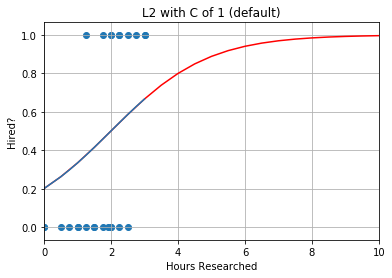

In [54]:
a = logreg.coef_[0][0]
b = logreg.intercept_[0]

plt.figure()
plt.scatter(cr['Hours Researched'], cr['Hired'])
plt.plot(x_points, sigmoid_curve(a*x_points + b), color='red')
plt.plot(cr['Hours Researched'].values, sigmoid_curve(a*cr['Hours Researched'].values + b))
plt.grid()
plt.xlim(0,10)
plt.xlabel('Hours Researched')
plt.ylabel('Hired?')
plt.title('L2 with C of 1 (default)')
plt.show()

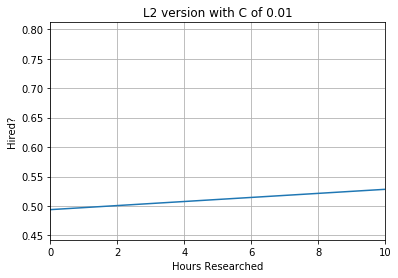

In [42]:
a = logregL2.coef_[0][0]
b = logregL2.intercept_[0]

plt.figure()
plt.scatter(cr['Hours Researched'], cr['Hired'])
plt.plot(x_points, sigmoid_curve(a*x_points + b))
plt.grid()
plt.xlim(0,10)
plt.xlabel('Hours Researched')
plt.ylabel('Hired?')
plt.title('L2 version with C of 0.01')
plt.show()

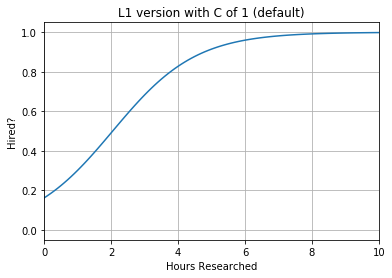

In [43]:
a = logregL1.coef_[0][0]
b = logregL1.intercept_[0]

plt.figure()
plt.scatter(cr['Hours Researched'], cr['Hired'])
plt.plot(x_points, sigmoid_curve(a*x_points + b))
plt.grid()
plt.xlim(0,10)
plt.xlabel('Hours Researched')
plt.ylabel('Hired?')
plt.title('L1 version with C of 1 (default)')
plt.show()

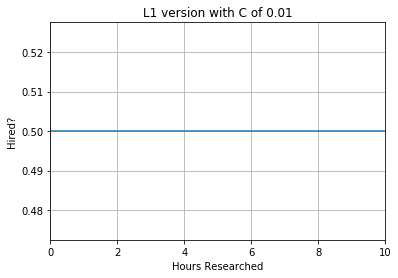

In [44]:
a = logregL1_c.coef_[0][0]
b = logregL1_c.intercept_[0]

plt.figure()
plt.scatter(cr['Hours Researched'], cr['Hired'])
plt.plot(x_points, sigmoid_curve(a*x_points + b))
plt.grid()
plt.xlim(0,10)
plt.xlabel('Hours Researched')
plt.ylabel('Hired?')
plt.title('L1 version with C of 0.01')
plt.show()

In [ ]:
#We see thesw graphs look really different, but we just want to be able to see where the cutoff (50%) is

Compared to the earlier graphs these look really odd. The second function looks more like a line (also notice where it crosses the $0.5$ threshold). This is mainly because we tried rather extreme values for the regularization weights. But it does illustrate the effect that regularization can have on the model. For a more direct example let's look at the classification accuracy:

In [57]:
#Recall X is the independent variable and Y is the dependent variable
#logreg has already been fitted to X and Y
print("The classification accuracy with L2 (default C):", logreg.score(X,Y)* 100 , "%")
print("The classification accuracy with L2 with C of 0.1:", logregL2_c.score(X,Y)* 100 , "%")
print("The classification accuracy with L2 with C of 0.01:", logregL2.score(X,Y)* 100 , "%")

#Recall X is the independent variable and Y is the dependent variable
#logreg has already been fitted to X and Y
print("The classification accuracy with L1 (default C):", logregL1.score(X,Y)* 100 , "%")
print("The classification accuracy with L1 with C of 0.01:", logregL1_c.score(X,Y)* 100 , "%")

The classification accuracy with L2 (default C): 76.0 %
The classification accuracy with L2 with C of 0.1: 76.0 %
The classification accuracy with L2 with C of 0.01: 72.0 %
The classification accuracy with L1 (default C): 76.0 %
The classification accuracy with L1 with C of 0.01: 60.0 %


The model using $L2$ regularization actually became less acurate! A lower classification accuracy doesen't automatically imply that a model is worse, it could be it is able to better generalize to more data (it does not overfit). Later on we will see various ways to evaluate the performance of models and how to pick the various parameters.

## Beyond Two Classes

While being able to differentiate between two cases (i.e is it yes/no?) is useful in many situations (will someone get hired, what is the probability of a car crash) it would be good to determine which of some arbitrary (but finite) number of cases happens. Multiclass problems arise in a variety of domains, where will Amazon locate their new headquarters, what inbox does an email belong in or which employee should we promote?

### Multi-Class Logistic Regression

It is easy to expand *logistic regression* from a binary classification system into a multi class one. The key insight from the two class example is that $s(x)$ is the probability that $x$ belongs to class $1$. This can also be thought of as the probability that $x$ does not belong to a class besides $1$. This other set of classes is simply all those not equal class $1$ (this could be one other class or several). 

**For example: if you have 3 classes, you asses if it belongs to class 1 (yes/no), class 2 (yes/no), class 3(yes/no) and take a vote of these**

If we had $k$ classes we needed to differentiate between we could build $k$ different models, each of which estimates the probability that a point belongs to a particular class. We would have several logistic functions:

$$(s_1, \cdots, s_k)$$

Where  $s_j(x)$ can be thought of as how confident our model is that a data point with features $x$ belongs to class $j$. To pick the class we assign $x$ to we just take the $j$ where its correspponding $s_j(x)$ with the highest value. This is called *one vs all* classification (for each class we train a sub-model which differentiates that class from all other classes). There are other methods to handle multi class problems, we will cover them at a later date.

Most software packages handle the multiclass logic for us, in `scikit` we don't even need to specify that it is a special case, we just need to create and fit the model as before:

In [58]:
# Generate some 3 class data (in two dimensions)
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

In [59]:
#Fit the model
clf = linear_model.LogisticRegression()
clf.fit(X, y)
# print the training scores
print("scores : " + str(clf.score(X, y)))

scores : 0.971


C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


We can visualize the the multiclass model (don't worry about how this code works). Each dot is a datapoint (its colour is the dependent variable). The dashed lines each represent a *one vs all* sub-model and the solid background colour represents the overall model's decision. Notice the region in the middle represents an area where each one vs all sub-model feels points are more likely to belong to another class, since the model still needs to make some decision it takes the class that least rejects the points in that area.

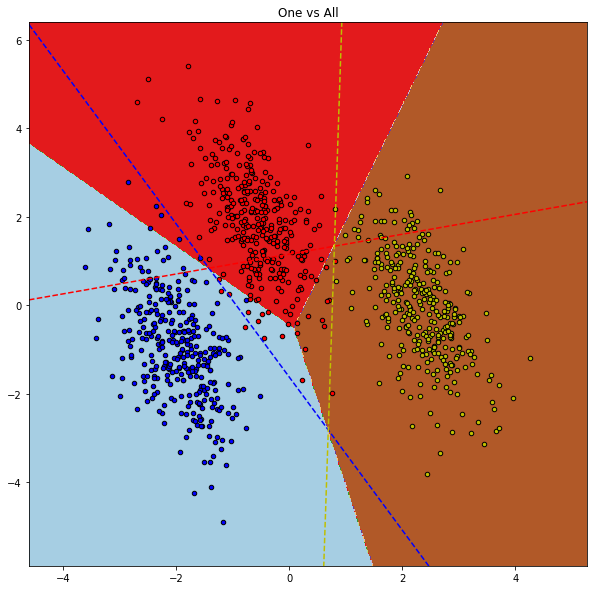

In [63]:
# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,10))
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.title("One vs All")
plt.axis('tight')

# Plot also the training points
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                edgecolor='black', s=20)

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_

def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color)

for i, color in zip(clf.classes_, colors):
    plot_hyperplane(i, color)

plt.show()

In [ ]:
#when looking at this in isolation, the lines represent the cutoff
#Example blue line is the cutoff region between blue and non-blue.
#The shades regions are what we get after we combine the threshold for each class. The shaded regions then become what we could use to classify a new point

### Looking Forward

We've seen several models for linking dependent variables to independent variables. Linear regression models a change in the independent variable as a linear shift in the dependent variable. Logistic regression models how changes with the independent variable affect the probability that the dependent variable belongs to some class.

These methods are known as linear models. We used some linear combination of the features of the independent variable $f(x) = \beta_0 + \beta_1 \cdot x_1 + \cdots + \beta_d \cdot x_d$ (possibly combining it with another function such as the sigmoid function) to make our prediction.

These belong to a general class of models called **Generalized Linear Models**. These models can capture almost any linear relation between dependent and independent variables. We'll explore these further in future lessons.